In [ ]:
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [6]:
train_DS = MNIST('./content', train=True, download=True, transform=img_transform)
val_DS = MNIST('./content', train=False, download=True, transform=img_transform)

In [7]:
from torch.utils.data import DataLoader

batch_size = 128
trn_dl = DataLoader(train_DS, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_DS, batch_size=batch_size, shuffle=False)

In [3]:
%pip install -q torchsummary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\guilh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
import torch.nn as nn

class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoEncoder().to(device)
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
         MaxPool2d-3             [-1, 32, 7, 7]               0
            Conv2d-4             [-1, 64, 4, 4]          18,496
              ReLU-5             [-1, 64, 4, 4]               0
         MaxPool2d-6             [-1, 64, 3, 3]               0
   ConvTranspose2d-7             [-1, 32, 7, 7]          18,464
              ReLU-8             [-1, 32, 7, 7]               0
   ConvTranspose2d-9           [-1, 16, 15, 15]          12,816
             ReLU-10           [-1, 16, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              65
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 50,161
Trainable params: 50,161
Non-trainable params: 0
---------------------------------

In [10]:
def train_batch(input, model, optimizer, criterion):
    model.train()
    input = input.to(device)
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    input = input.to(device)
    output = model(input)
    loss = criterion(output, input)
    return loss

model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay=1e-5)

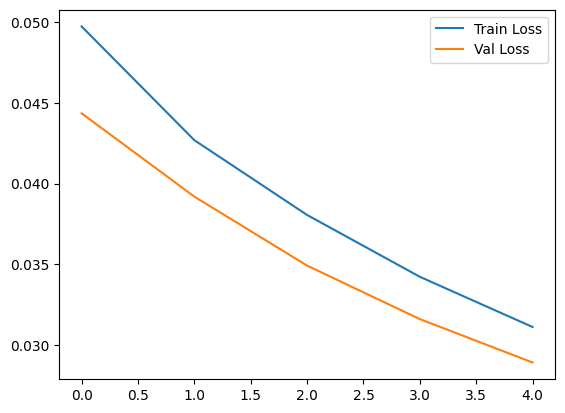

In [13]:
from fastprogress import master_bar, progress_bar

num_epochs = 5
train_losses, val_losses = [], []

mb = master_bar(range(num_epochs))
for epoch in mb:
    trn_loss_epoch = 0
    for data, _ in progress_bar(trn_dl, parent=mb):
        loss = train_batch(data, model, optimizer, criterion)
        trn_loss_epoch += loss.item() * data.size(0)
        mb.child.comment = f"Train Loss: {loss.item():.4f}"
    train_losses.append(trn_loss_epoch / len(train_DS))

    val_loss_epoch = 0
    for data, _ in progress_bar(val_dl, parent=mb):
        loss = validate_batch(data, model, criterion)
        val_loss_epoch += loss.item() * data.size(0)
        mb.child.comment = f"Val Loss: {loss.item():.4f}"
    val_losses.append(val_loss_epoch / len(val_DS))

    mb.write(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

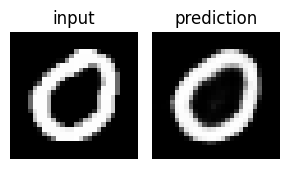

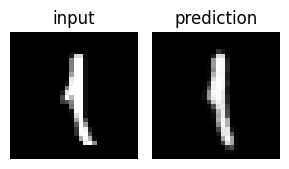

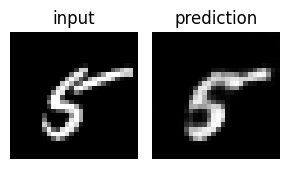

In [14]:
model.eval()

for _ in range(3):
    ix = np.random.randint(len(val_DS))
    im, _ = val_DS[ix]
    
    im = im.to(device)
    
    with torch.no_grad():
        _im = model(im[None])[0].cpu()  # batch dim + retorna para CPU
    
    fig, ax = plt.subplots(1, 2, figsize=(3, 3))
    show(im[0].cpu(), ax=ax[0], title='input')  # mostra a imagem original
    show(_im[0], ax=ax[1], title='prediction')  # mostra a reconstrução
    plt.tight_layout()
    plt.show()

In [15]:
latent_vectors = []
classes = []

In [17]:
for im, clss in val_dl:
    im = im.to(device)
    with torch.no_grad():
        latent = model.encoder(im).view(im.size(0), -1)  # flatten the output
    latent_vectors.append(latent.cpu())
    classes.append(clss)

In [ ]:
latent_vectors = torch.cat(latent_vectors)

In [20]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [21]:
clustered = tsne.fit_transform(latent_vectors.numpy())

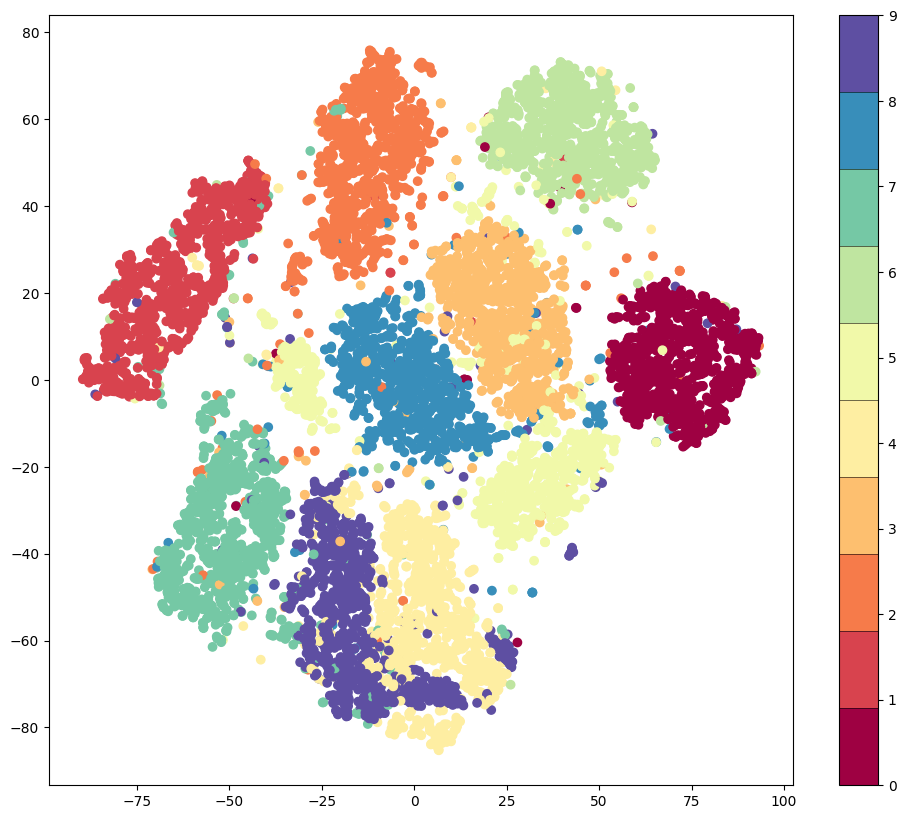

In [ ]:
fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap('Spectral', 10) # cria um mapa de cores com 10 classes
all_classes = torch.cat(classes).numpy() # Concatena todas as classes
plt.scatter(*zip(*clustered), c=all_classes, cmap=cmap) # *zip(*clustered) desempacota as coordenadas x e y
plt.colorbar(drawedges=True)